In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#import all the libraries

#common libraries
import numpy as np
import pandas as pd
import time
import os
import math
import missingno as msno 


#library for visualization

from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
plt.style.use('ggplot')

#sklearn libraries 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


In [3]:
cd /kaggle/working

/kaggle/working


In [4]:
#Read the data

data=pd.read_csv("/kaggle/input/titanic/train.csv")
data_predict=pd.read_csv("/kaggle/input/titanic/test.csv")
data_predict_ori=data_predict.copy()
data.head(100)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
98,99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S


# Pre-data processing

In [5]:
#overall survival and death rate
len_sur=len(data["Survived"])
total_survival_count=list(data["Survived"]).count(1)
total_death_count=list(data["Survived"]).count(0)

survival_rate=(total_survival_count/len_sur)
death_rate=1-survival_rate
print (survival_rate,death_rate)


0.3838383838383838 0.6161616161616161


In [6]:
# death rate and survival rate by men and women
data_female = data[data['Sex'] == 'female']
female_survivors=list(data_female["Survived"]).count(1)
female_survivor_rate=female_survivors/total_survival_count
print (female_survivor_rate)

data_male = data[data['Sex'] == 'male']
male_survivors=list(data_male["Survived"]).count(1)
male_survivor_rate=male_survivors/total_survival_count
print (male_survivor_rate)



0.6812865497076024
0.31871345029239767


In [7]:
print (data_predict.isnull().sum())
print (data.isnull().sum())


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [8]:
#check for missing values
data[data["Embarked"].isnull()]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [9]:
avg=data.groupby(["Sex","Pclass"]).median()["Age"].mean()
avg_test=data_predict.groupby(["Sex","Pclass"]).median()["Age"].mean()
data["Age"]=data["Age"].replace(np.nan,avg)
data_predict["Age"]=data_predict["Age"].replace(np.nan,avg_test)
data_predict["Fare"] = data_predict["Fare"].replace(np.NaN, data_predict["Fare"].mean())
data["Embarked"] = data["Embarked"].replace(np.NaN,"S")




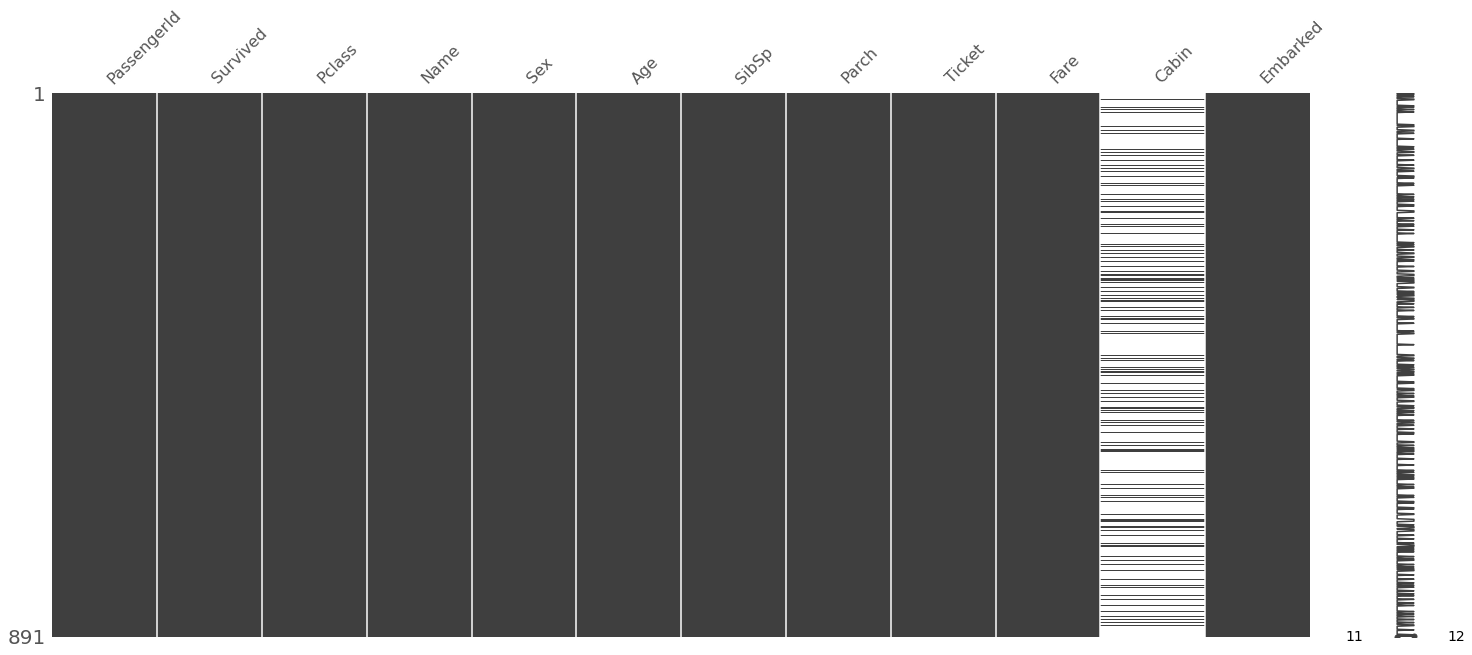

In [10]:
#plot the missing values using missingno library
msno.matrix(data)


In [11]:
#drop the unnecessary colums which for sure wont have any effect on training/prediction
data=data.drop(["PassengerId","Name","Cabin"],axis=1)
data_predict=data_predict.drop(["PassengerId","Name","Cabin"],axis=1)


In [12]:
#Check is all the missing values have been replaced or not
print (data_predict.isnull().sum())
print (data.isnull().sum())


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64


In [13]:
#The categorical values should be encoded  
le = LabelEncoder() 
one_hot = OneHotEncoder()

  
data['Sex']= le.fit_transform(data['Sex']) 
data_predict['Sex']= le.fit_transform(data_predict['Sex']) 

oe_results= one_hot.fit_transform(data[['Embarked']])
oe_results_pre= one_hot.fit_transform(data_predict[['Embarked']])

data = data.join(pd.DataFrame(oe_results.toarray(), columns=one_hot.categories_))
data_predict= data_predict.join(pd.DataFrame(oe_results_pre.toarray(), columns=one_hot.categories_))




In [14]:
data=data.drop(["Ticket","Embarked"],axis=1)
data_predict=data_predict.drop(["Ticket","Embarked"],axis=1)

In [15]:
#check for correlation matrix [onlt for numeric values]
data.corr()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,"(C,)","(Q,)","(S,)"
Survived,1.000000,-0.338481,-0.543351,-0.070423,-0.035322,0.081629,0.257307,0.168240,0.003650,-0.149683
Pclass,-0.338481,1.000000,0.131900,-0.330176,0.083081,0.018443,-0.549500,-0.243292,0.221009,0.074053
Sex,-0.543351,0.131900,1.000000,0.084520,-0.114631,-0.245489,-0.182333,-0.082853,-0.074115,0.119224
Age,-0.070423,-0.330176,0.084520,1.000000,-0.232493,-0.180016,0.090891,0.032246,-0.011601,-0.020948
SibSp,-0.035322,0.083081,-0.114631,-0.232493,1.000000,0.414838,0.159651,-0.059528,-0.026354,0.068734
Parch,0.081629,0.018443,-0.245489,-0.180016,0.414838,1.000000,0.216225,-0.011069,-0.081228,0.060814
Fare,0.257307,-0.549500,-0.182333,0.090891,0.159651,0.216225,1.000000,0.269335,-0.117216,-0.162184
"(C,)",0.168240,-0.243292,-0.082853,0.032246,-0.059528,-0.011069,0.269335,1.000000,-0.148258,-0.782742
"(Q,)",0.003650,0.221009,-0.074115,-0.011601,-0.026354,-0.081228,-0.117216,-0.148258,1.000000,-0.499421
"(S,)",-0.149683,0.074053,0.119224,-0.020948,0.068734,0.060814,-0.162184,-0.782742,-0.499421,1.000000


parch and sibsp seem to have co-linearity(mulicolinearity).If you wish you can drop one of them and check for the accruracy and decide to keep both of them or only one

In [16]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,"(C,)","(Q,)","(S,)"
0,0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,0,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,0,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0


In [17]:
data_predict.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,"(C,)","(Q,)","(S,)"
0,3,1,34.5,0,0,7.8292,0.0,1.0,0.0
1,3,0,47.0,1,0,7.0000,0.0,0.0,1.0
2,2,1,62.0,0,0,9.6875,0.0,1.0,0.0
3,3,1,27.0,0,0,8.6625,0.0,0.0,1.0
4,3,0,22.0,1,1,12.2875,0.0,0.0,1.0


In [18]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,"(C,)","(Q,)","(S,)"
0,0,3,1,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,0,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,0,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,0,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,1,35.0,0,0,8.0500,0.0,0.0,1.0


In [19]:
data_predict.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,"(C,)","(Q,)","(S,)"
0,3,1,34.5,0,0,7.8292,0.0,1.0,0.0
1,3,0,47.0,1,0,7.0000,0.0,0.0,1.0
2,2,1,62.0,0,0,9.6875,0.0,1.0,0.0
3,3,1,27.0,0,0,8.6625,0.0,0.0,1.0
4,3,0,22.0,1,1,12.2875,0.0,0.0,1.0


In [20]:
#scale the all the columns so thar they have the same range
standscaler=StandardScaler()
data_predict = pd.DataFrame(standscaler.fit_transform(data_predict),columns = data_predict.columns)



In [21]:
X = data.drop('Survived',axis = 1)
y = data['Survived']

In [22]:
X = pd.DataFrame(standscaler.fit_transform(X),columns = X.columns)


In [23]:

X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,"(C,)","(Q,)","(S,)"
0,0.827377,0.737695,-0.595793,0.432793,-0.473674,-0.502445,-0.482043,-0.307562,0.615838
1,-1.566107,-1.355574,0.635449,0.432793,-0.473674,0.786845,2.074505,-0.307562,-1.623803
2,0.827377,-1.355574,-0.287982,-0.474545,-0.473674,-0.488854,-0.482043,-0.307562,0.615838
3,-1.566107,-1.355574,0.404591,0.432793,-0.473674,0.420730,-0.482043,-0.307562,0.615838
4,0.827377,0.737695,0.404591,-0.474545,-0.473674,-0.486337,-0.482043,-0.307562,0.615838


In [24]:
data_predict.isnull().sum()

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
(C,)      0
(Q,)      0
(S,)      0
dtype: int64

# Training the model

In [25]:

seed = 7
# preparing models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(learning_rate=0.01)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('NB', RandomForestClassifier(n_estimators=10,criterion = 'entropy')))

models.append(('XGBClassifier', XGBClassifier()))

for name,model in models:
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2)
    
    
    cv_results = model_selection.cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean()
    
    print (cv_results)



0.7968414481897629
0.7923408239700374
0.8198626716604245
0.7801123595505618
0.7771910112359551
0.801916354556804
0.8142322097378278


In [26]:
#choose the final model depending on Cross validation accuracy
classifier=GradientBoostingClassifier(learning_rate=0.01)
# classifier=GaussianNB()
classifier.fit(X,y)
y_prdict_t=classifier.predict(X)



# Evaluate accuracy of the model

In [27]:
acc_score=accuracy_score(y,y_prdict_t)
prec_score=precision_score(y,y_prdict_t)
confusion_mat=confusion_matrix(y,y_prdict_t)
y_predict=classifier.predict(data_predict)

In [28]:
print (acc_score)

0.8327721661054994


In [29]:
submission = pd.DataFrame({'PassengerId':data_predict_ori["PassengerId"],'Survived':y_predict})

In [30]:
len(submission)

418

In [31]:
submission.to_csv('submission.csv',index=False)